In [1]:
pip install netket

INFO: pip is looking at multiple versions of flax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 kB 18.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.7/177.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.1/447.1 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.3/354.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [36]:
import netket as nk
L = 8
hilbert = nk.hilbert.Spin(s=0.5, N=L)

graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

ha = nk.operator.Heisenberg(hilbert, graph=graph)
# RBM
ma = nk.models.RBM(alpha=1)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)

vs = nk.vqs.MCState(sampler=sampler, model=ma, n_samples=1000)

op = nk.optimizer.Sgd(learning_rate=0.005)
gs = nk.VMC(hamiltonian=ha, optimizer=op, variational_state=vs)
gs.run(n_iter=300)
print("Ground state energy:", vs.expect(ha).mean)


  0%|          | 0/300 [00:00<?, ?it/s]

Ground state energy: -11.435752585059655


In [3]:
import netket as nk
import jax
import jax.numpy as jnp
import flax.linen as nn

# Custom feedforward neural network
class CustomFFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x.squeeze(-1)

L = 10
hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
H = nk.operator.Heisenberg(hilbert=hilbert, graph=graph)
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)

model = CustomFFNN()
vs = nk.vqs.MCState(sampler=sampler, model=model, n_samples=1000)
opt = nk.optimizer.Sgd(learning_rate=0.05)
gs = nk.driver.VMC(hamiltonian=H, optimizer=opt, variational_state=vs)

log = gs.run(n_iter=500, out='log')


/opt/anaconda3/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:299: UserWarning: n_samples=1000 (1000 per JAX device) does not divide n_chains=16, increased to 1008 (1008 per JAX device)
  self.n_samples = n_samples


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

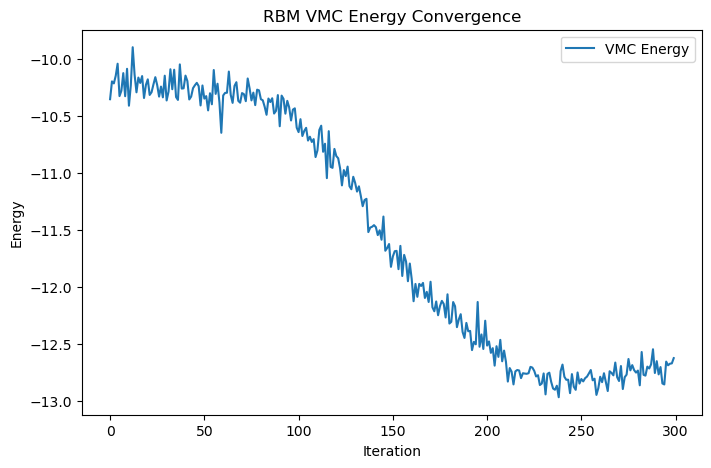

In [42]:
import netket as nk
import matplotlib.pyplot as plt
L = 10  

hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)

ha = nk.operator.Heisenberg(hilbert, graph=graph)
ma = nk.models.RBM(alpha=1)  # hidden units = alpha * N
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
vs = nk.vqs.MCState(sampler=sampler, model=ma, n_samples=4096)
op = nk.optimizer.Sgd(learning_rate=0.003)
gs = nk.VMC(hamiltonian=ha, optimizer=op, variational_state=vs)

energy_history = []

def record_energy(step, log_data, vmc):
    energy_history.append(log_data["Energy"].mean)
    return True  

gs.run(n_iter=300, callback=record_energy)

plt.figure(figsize=(8,5))
plt.plot(energy_history, label="VMC Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("RBM VMC Energy Convergence")
plt.legend()
plt.show()


In [82]:
hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Chain(length=L, pbc=True)
ha = nk.operator.Heisenberg(hilbert=hilbert, graph=graph)

exact_energy = nk.exact.lanczos_ed(ha, compute_eigenvectors=False)[0]

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


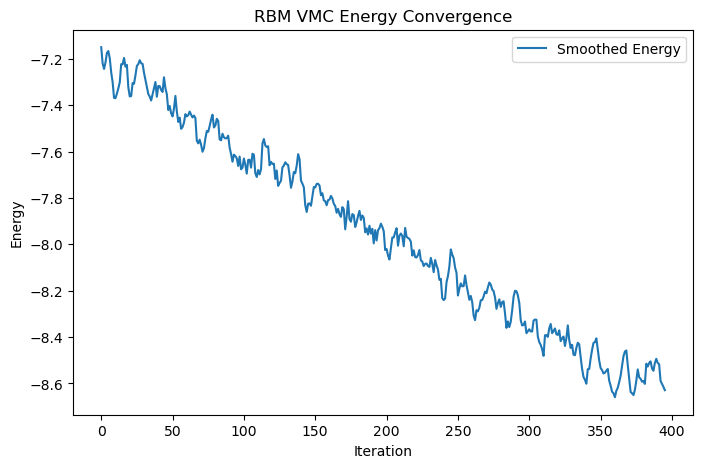

In [113]:
import numpy as np

def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

rbm_smoothed_energy = moving_average(energy_history, window=10)

plt.figure(figsize=(8,5))
plt.plot(smoothed_energy, label="Smoothed Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("RBM VMC Energy Convergence")
plt.legend()
plt.show()



=== Running L=6 ===


  0%|          | 0/400 [00:00<?, ?it/s]

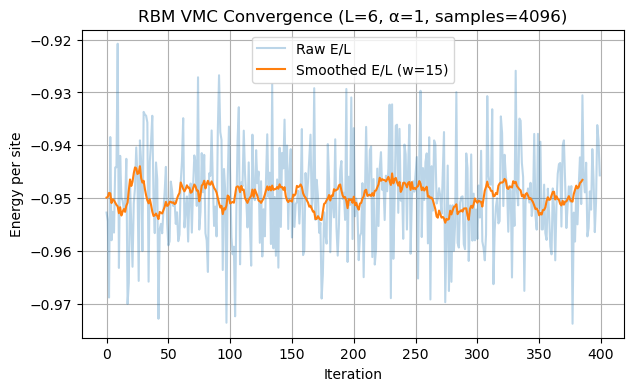


=== Running L=8 ===


  0%|          | 0/400 [00:00<?, ?it/s]

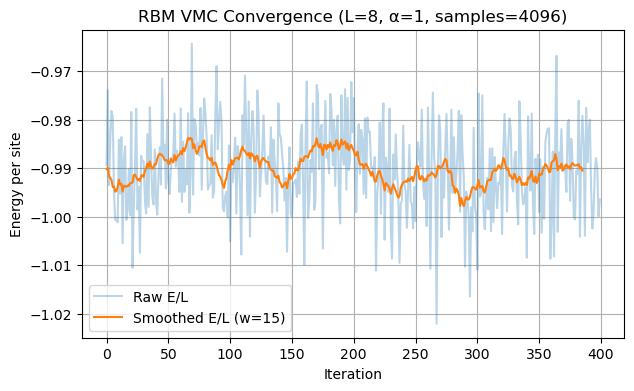


=== Running L=10 ===


  0%|          | 0/400 [00:00<?, ?it/s]

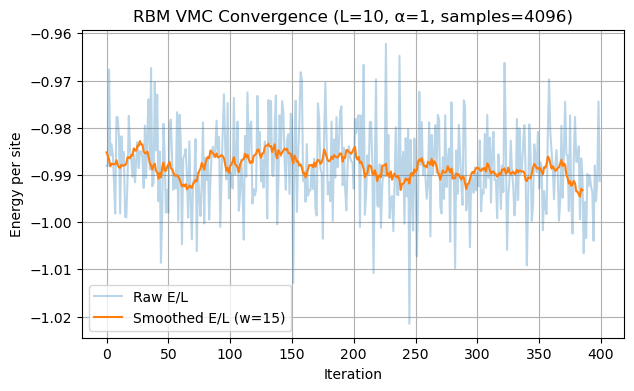

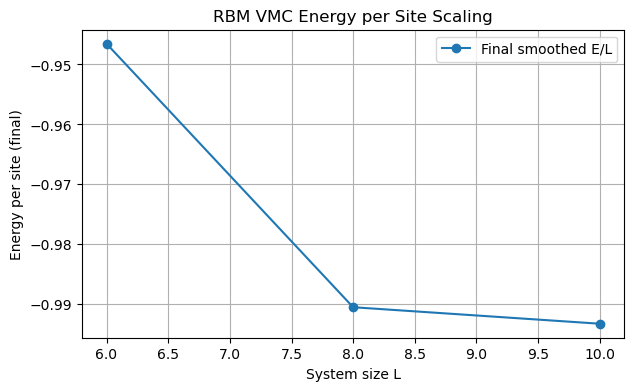

In [100]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt

L_list = [6, 8, 10]
base_lr = 1e-5               # your current LR
iters   = 400                 # a bit more than 300 for stability
ma_alpha_small = 1
ma_alpha_large = 2            # use when L >= 12
samples_small = 4096
samples_large = 16384         # try 32768 if still noisy
discard_per_chain = 1000      # burn-in to reduce bias
smooth_window = 15            # moving average window for plotting

def moving_average(x, w):
    if len(x) < w:
        return np.array(x, dtype=float)
    return np.convolve(x, np.ones(w)/w, mode='valid')

# Store final (smoothed) energy per site for scaling plot
E_per_site_final = []

for L in L_list:
    print(f"\n=== Running L={L} ===")
    hilbert = nk.hilbert.Spin(s=0.5, N=L)
    graph   = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
    H       = nk.operator.Heisenberg(hilbert, graph=graph)

    # Expressivity & sampling scale with system size
    alpha   = ma_alpha_small if L <= 10 else ma_alpha_large
    n_samp  = samples_small   if L <= 10 else samples_large

    # RBM ansatz
    model = nk.models.RBM(alpha=alpha)

    # Sampler & variational state
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
    vs = nk.vqs.MCState(
        sampler=sampler,
        model=model,
        n_samples=n_samp,
        n_discard_per_chain=discard_per_chain
    )

    # Optimizer (SGD). If you like, try Adam for faster settling.
    opt = nk.optimizer.Sgd(learning_rate=base_lr)

    # Optional: Natural Gradient (Stochastic Reconfiguration) preconditioner.
    # This often stabilizes training at larger L.
    # Uncomment to use:
    # sr = nk.optimizer.SR(diag_shift=1e-3)
    # vmc = nk.VMC(hamiltonian=H, optimizer=opt, variational_state=vs, preconditioner=sr)

    vmc = nk.VMC(hamiltonian=H, optimizer=opt, variational_state=vs)

    # Record energy every iteration
    energy_hist = []
    def cb(step, log_data, driver):
        # NetKet 3.19: Energy is in log_data["Energy"].mean
        energy_hist.append(log_data["Energy"].mean)
        return True

    vmc.run(n_iter=iters, callback=cb)

    # Smooth and store final value per site
    energy_hist = np.array(energy_hist, dtype=float)
    energy_sm   = moving_average(energy_hist, smooth_window)
    final_E_per_site = (energy_sm[-1] if len(energy_sm)>0 else energy_hist[-1]) / L
    E_per_site_final.append(final_E_per_site)

    # Plot per-L convergence (smoothed)
    plt.figure(figsize=(7,4))
    plt.plot(energy_hist/L, alpha=0.3, label="Raw E/L")
    if len(energy_sm) > 0:
        plt.plot(energy_sm/L, label=f"Smoothed E/L (w={smooth_window})")
    plt.xlabel("Iteration")
    plt.ylabel("Energy per site")
    plt.title(f"RBM VMC Convergence (L={L}, α={alpha}, samples={n_samp})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Scaling plot
plt.figure(figsize=(7,4))
plt.plot(L_list, E_per_site_final, "o-", label="Final smoothed E/L")
plt.xlabel("System size L")
plt.ylabel("Energy per site (final)")
plt.title("RBM VMC Energy per Site Scaling")
plt.grid(True)
plt.legend()
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

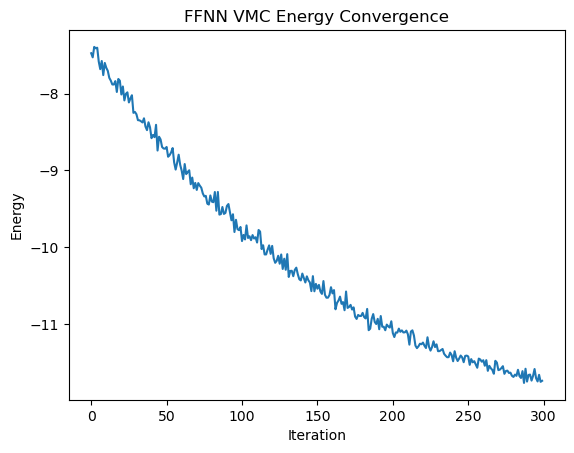

In [81]:
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax.linen as nn

# Define system
L = 10
hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
ha = nk.operator.Heisenberg(hilbert, graph=graph)

# Define FFNN model using Flax
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10 * x.shape[-1],
                     param_dtype=jnp.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.1),
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jax.numpy.sum(x, axis=-1)

ma = FFNN()

# Sampler and variational state
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
vs = nk.vqs.MCState(sampler=sampler, model=ma, n_samples=5000)

# Optimizer and VMC driver
op = nk.optimizer.Sgd(learning_rate=0.0001)
gs = nk.VMC(hamiltonian=ha, optimizer=op, variational_state=vs)

# Run optimization
energy_history = []

def record(step, log_data, vmc):
    energy_history.append(log_data["Energy"].mean)
    return True

gs.run(n_iter=300, callback=record)

# Plot the convergence
plt.plot(energy_history)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("FFNN VMC Energy Convergence")
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:299: UserWarning: n_samples=5000 (5000 per JAX device) does not divide n_chains=16, increased to 5008 (5008 per JAX device)
  self.n_samples = n_samples


  0%|          | 0/300 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


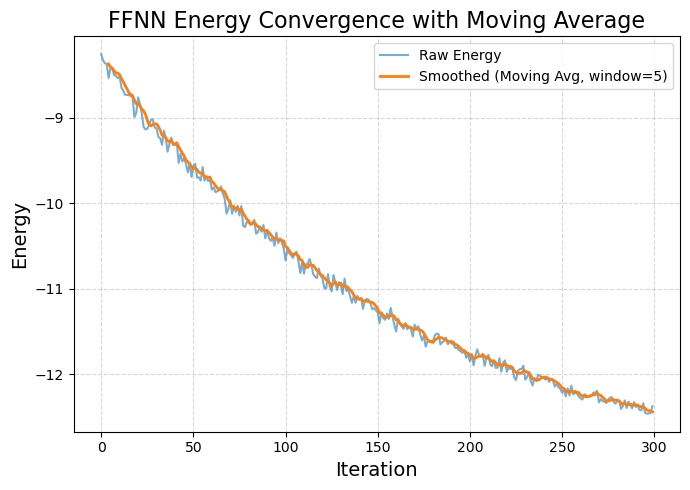

In [101]:
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax.linen as nn

# -----------------------------
# Moving Average Helper
# -----------------------------
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# -----------------------------
# Parameters
# -----------------------------
L = 10
hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
ha = nk.operator.Heisenberg(hilbert, graph=graph)

# -----------------------------
# FFNN Definition
# -----------------------------
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10 * x.shape[-1],
                     param_dtype=jnp.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.1),
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

ma = FFNN()

# -----------------------------
# Sampler & State
# -----------------------------
sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
vs = nk.vqs.MCState(sampler=sampler, model=ma, n_samples=5000)

# -----------------------------
# Optimizer & VMC
# -----------------------------
op = nk.optimizer.Sgd(learning_rate=0.0001)
gs = nk.VMC(hamiltonian=ha, optimizer=op, variational_state=vs)

energy_history = []

def record(step, log_data, vmc):
    energy_history.append(log_data["Energy"].mean)
    return True

gs.run(n_iter=300, callback=record)

# -----------------------------
# Apply moving average
# -----------------------------
smoothed_energy = moving_average(np.array(energy_history), window_size=5)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(7,5))
plt.plot(energy_history, label="Raw Energy", alpha=0.6)
plt.plot(range(4, len(smoothed_energy)+4), smoothed_energy, label="Smoothed (Moving Avg, window=5)", linewidth=2)
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.title("FFNN Energy Convergence with Moving Average", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



Running FFNN for L = 6...


/opt/anaconda3/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:299: UserWarning: n_samples=5000 (5000 per JAX device) does not divide n_chains=16, increased to 5008 (5008 per JAX device)
  self.n_samples = n_samples


  0%|          | 0/400 [00:00<?, ?it/s]


Running FFNN for L = 8...


  0%|          | 0/400 [00:00<?, ?it/s]


Running FFNN for L = 10...


  0%|          | 0/400 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


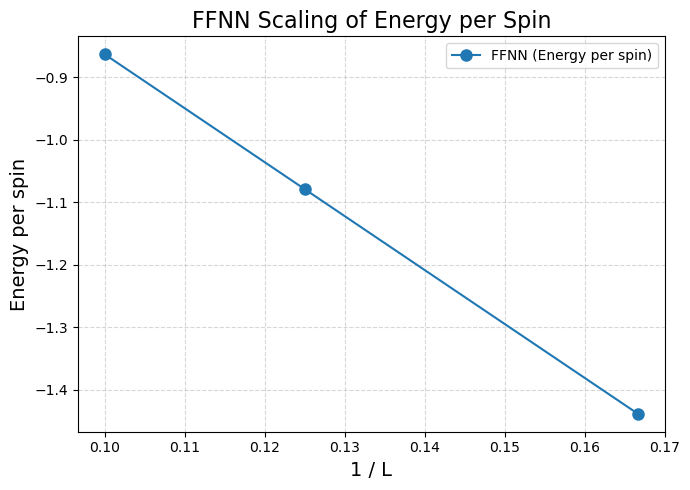

In [112]:
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax.linen as nn

# -----------------------------
# Moving Average Helper
# -----------------------------
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# -----------------------------
# FFNN Definition
# -----------------------------
class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10 * x.shape[-1],
                     param_dtype=jnp.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.1),
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

# -----------------------------
# Scaling experiment
# -----------------------------
system_sizes = [6, 8, 10]
final_energies_per_spin = []

for L in system_sizes:
    print(f"\nRunning FFNN for L = {L}...")
    
    hilbert = nk.hilbert.Spin(s=0.5, N=L)
    graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
    ha = nk.operator.Heisenberg(hilbert, graph=graph)
    
    ma = FFNN()
    sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
    vs = nk.vqs.MCState(sampler=sampler, model=ma, n_samples=5000)
    
    op = nk.optimizer.Sgd(learning_rate=0.00001)
    gs = nk.VMC(hamiltonian=ha, optimizer=op, variational_state=vs)
    
    energy_history = []
    
    def record(step, log_data, vmc):
        energy_history.append(log_data["Energy"].mean)
        return True
    
    gs.run(n_iter=400, callback=record)
    
    # Smooth energy
    ffnn_smoothed_energy = moving_average(np.array(energy_history), window_size=5)
    final_energy = smoothed_energy[-1]  # Take last smoothed value
    
    # Store per spin
    final_energies_per_spin.append(final_energy / L)

# -----------------------------
# Plot scaling: E/L vs 1/L
# -----------------------------
inv_L = [1.0 / L for L in system_sizes]

plt.figure(figsize=(7,5))
plt.plot(inv_L, final_energies_per_spin, 'o-', markersize=8, label="FFNN (Energy per spin)")
plt.xlabel("1 / L", fontsize=14)
plt.ylabel("Energy per spin", fontsize=14)
plt.title("FFNN Scaling of Energy per Spin", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

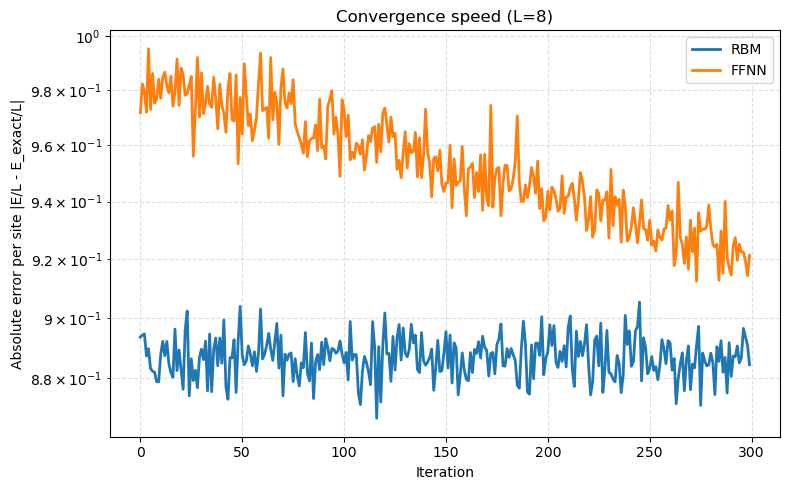

RBM: first iteration with error per site <= 0.001: None
FFNN: first iteration with error per site <= 0.001: None


In [120]:
import netket as nk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import flax.linen as nn

L = 8
hilbert = nk.hilbert.Spin(s=0.5, N=L)
graph = nk.graph.Hypercube(length=L, n_dim=1, pbc=True)
H = nk.operator.Heisenberg(hilbert=hilbert, graph=graph)

# Exact ground-state energy for reference (ED/Lanczos)
E_exact = float(nk.exact.lanczos_ed(H, compute_eigenvectors=False)[0])
E_exact_site = E_exact / L

# Helper to record energies safely as real floats
def as_real(x):
    return float(np.real(x))


rbm_model = nk.models.RBM(alpha=1)
rbm_sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
rbm_vs = nk.vqs.MCState(sampler=rbm_sampler, model=rbm_model, n_samples=8000)
rbm_opt = nk.optimizer.Adam(learning_rate=0.00001)
rbm_vmc = nk.VMC(hamiltonian=H, optimizer=rbm_opt, variational_state=rbm_vs)

rbm_energy = []
def rbm_cb(step, log_data, driver):
    rbm_energy.append(as_real(log_data["Energy"].mean))
    return True

class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10 * x.shape[-1],
                     param_dtype=jnp.complex128,
                     kernel_init=nn.initializers.normal(stddev=0.1),
                     bias_init=nn.initializers.normal(stddev=0.1))(x)
        x = nk.nn.activation.log_cosh(x)
        return jnp.sum(x, axis=-1)

ffnn_model = FFNN()
ffnn_sampler = nk.sampler.MetropolisExchange(hilbert=hilbert, graph=graph)
ffnn_vs = nk.vqs.MCState(sampler=ffnn_sampler, model=ffnn_model, n_samples=8192)
ffnn_opt = nk.optimizer.Sgd(learning_rate=1e-5)
ffnn_vmc = nk.VMC(hamiltonian=H, optimizer=ffnn_opt, variational_state=ffnn_vs)

ffnn_energy = []
def ffnn_cb(step, log_data, driver):
    ffnn_energy.append(as_real(log_data["Energy"].mean))
    return True

n_iter = 300
rbm_vmc.run(n_iter=n_iter, callback=rbm_cb)
ffnn_vmc.run(n_iter=n_iter, callback=ffnn_cb)

rbm_err_site = np.abs(np.array(rbm_energy) - E_exact) / L
ffnn_err_site = np.abs(np.array(ffnn_energy) - E_exact) / L

plt.figure(figsize=(8,5))
plt.semilogy(rbm_err_site, label="RBM", linewidth=2)
plt.semilogy(ffnn_err_site, label="FFNN", linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Absolute error per site |E/L - E_exact/L|")
plt.title(f"Convergence speed (L={L})")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

tol = 1e-3  
def first_hit(err, tol):
    idx = np.where(err <= tol)[0]
    return int(idx[0]) if idx.size > 0 else None

rbm_hit = first_hit(rbm_err_site, tol)
ffnn_hit = first_hit(ffnn_err_site, tol)

print(f"RBM: first iteration with error per site <= {tol}: {rbm_hit}")
print(f"FFNN: first iteration with error per site <= {tol}: {ffnn_hit}")